## Poisson1D PINN

In [1]:
from __future__ import division, print_function

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

**Utils**

In [3]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):    
    plt.figure(figsize=(12,6))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc='upper right', frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.2, np.pi)
    plt.ylim(-1.5, 1.5)    
    plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="xx-large", 
             color="k",
             ha='left', 
             va='top')
    plt.axis("off")

In [5]:
style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"

In [6]:
def style_plot(x, y, x_data, y_data, yh, xp=None):
    style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Training data')
        if yh is not None:
            plt.plot(x, yh, label="Neural network prediction")
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations')
        plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')

**Main Problem**

In [7]:
def f_rhs(x):
  return -4*torch.sin(2 * x)

def exact_u(x):
  return torch.sin(2 * x)

def exact_u_singular(x):
  return x**0.7 * (x - torch.pi)

def f_singular_rhs(x):
  return -0.7 * 0.3 * (x**-1.3) * (x - torch.pi) + (0.7*x**-0.3) * (1) + (0.7 * x**-0.3)  

class FCN(nn.Module):  
  def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
    super().__init__()
    activation = nn.Tanh
    self.fcs = nn.Sequential(*[
        nn.Linear(N_INPUT, N_HIDDEN),
        activation()])
    self.fch = nn.Sequential(*[
                  nn.Sequential(*[
                      nn.Linear(N_HIDDEN, N_HIDDEN),
                      activation()]) for _ in range(N_LAYERS-1)])
    self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

  def forward(self, x):
    x = self.fcs(x)
    x = self.fch(x)
    x = self.fce(x)
    return x

### **Training data**

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([15, 1]) torch.Size([15, 1])


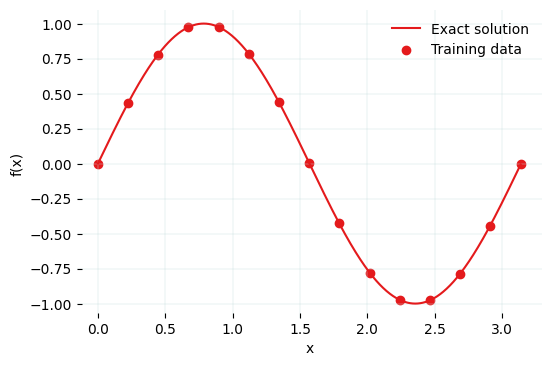

In [8]:
n_pts = 1000

x = np.array([np.pi/n_pts * i for i in range(n_pts)])
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = exact_u(x).view(-1, 1)
print(x.shape, y.shape)

num_samples = 15
indices = np.linspace(0, len(x)-1, num_samples, dtype=int)
x_data = x[indices]
y_data = y[indices]
print(x_data.shape, y_data.shape)

with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.plot(x, y, label="Exact solution")          
    plt.scatter(x_data, y_data, label='Training data')       
    plt.legend()
    
    plt.savefig('sen_func.png', dpi=300, bbox_inches='tight')

    plt.show()

### **Normal Neural Network**

In [9]:
torch.manual_seed(123)
model = FCN(1, 1, 10, 4)
model

FCN(
  (fcs): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
    )
  )
  (fce): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 361


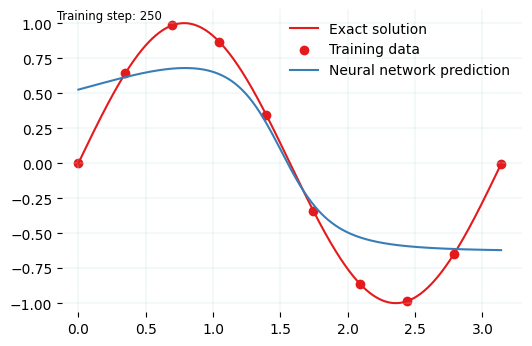

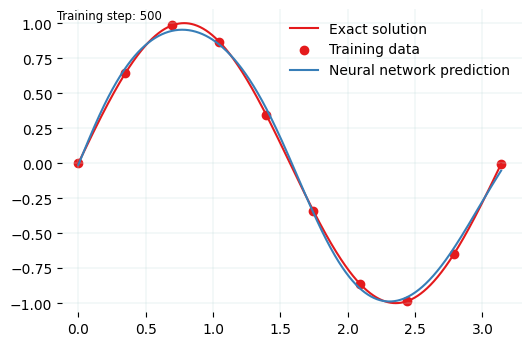

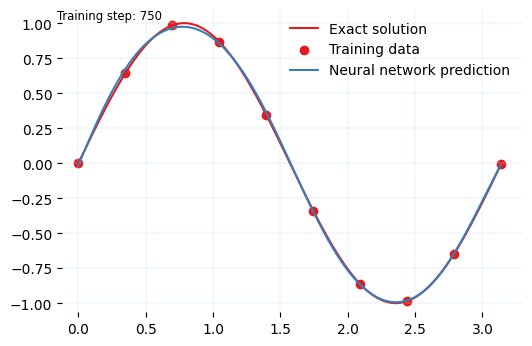

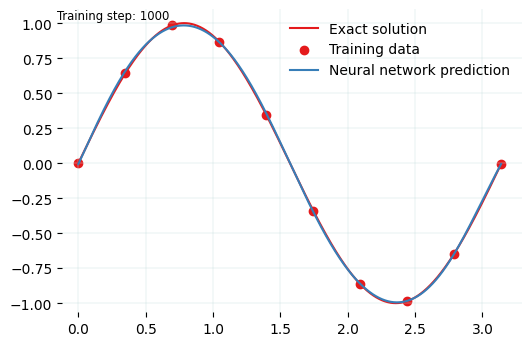

In [30]:
model = FCN(1, 1, 10, 4)
n_iterations = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(n_iterations):
  optimizer.zero_grad()
  yh = model(x_data)
  loss = torch.mean((yh-y_data)**2)
  loss.backward()
  optimizer.step()

  if (i+1) % 10 == 0:
    yh = model(x).detach()
    #plot_result(x, y, x_data, y_data, yh)
    style_plot(x, y, x_data, y_data, yh)
    file = "plots/nn_%.8i.png"%(i+1)    
    plt.savefig(file, bbox_inches=None, pad_inches=0.5, dpi=100, facecolor="white")
    files.append(file)

    if (i+1) % 250 == 0: plt.show()
    else: plt.close("all")
save_gif_PIL("ffnn_sen_data_gif.gif", files, fps=20, loop=0)

### **PINN**

In [17]:
x_physics = torch.linspace(0, torch.pi, n_pts).requires_grad_(True)
x_physics = x_physics.view(n_pts, 1)
x_physics.shape

torch.Size([1000, 1])

Loss at iteration 50: 7.3761
Loss at iteration 100: 4.2539
Loss at iteration 150: 1.6336
Loss at iteration 200: 0.6644
Loss at iteration 250: 0.1399


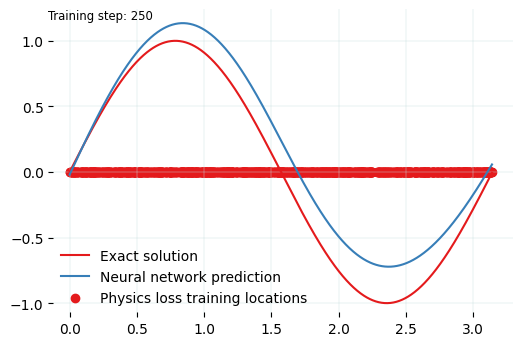

Loss at iteration 300: 0.0082
Loss at iteration 350: 0.0046
Loss at iteration 400: 0.0031
Loss at iteration 450: 0.0023
Loss at iteration 500: 0.0017


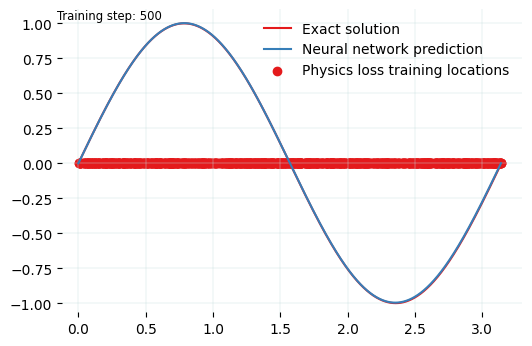

Loss at iteration 550: 0.0014
Loss at iteration 600: 0.0009
Loss at iteration 650: 0.0009
Loss at iteration 700: 0.0006
Loss at iteration 750: 0.0005


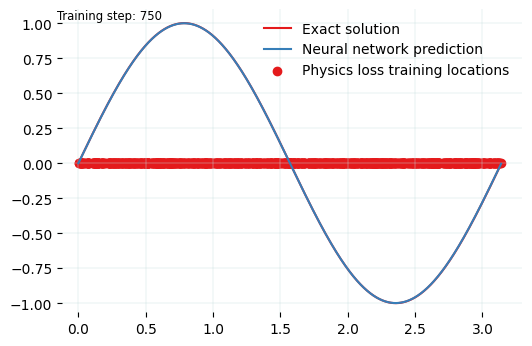

Loss at iteration 800: 0.0005
Loss at iteration 850: 0.0005
Loss at iteration 900: 0.0004
Loss at iteration 950: 0.0004
Loss at iteration 1000: 0.0004


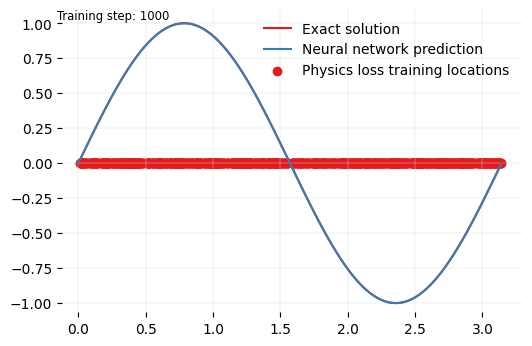

In [38]:
#x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)
iterations = 1000

torch.manual_seed(123)
model = FCN(1, 1, 10, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
losses = []
output_errors = []
L2_errors = []

for i in range(iterations):
    #x_physics = torch.linspace(0, torch.pi, n_pts).requires_grad_(True)
    #x_physics = x_physics.view(n_pts, 1)
    
    x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)
    optimizer.zero_grad()

    # Physic loss
    yhp = model(x_physics)
    du = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    ddu = torch.autograd.grad(du, x_physics, torch.ones_like(du), create_graph=True)[0]
    error_PDE = torch.mean((ddu - f_rhs(x_physics))**2)
    bc = model(torch.tensor([np.pi]))**2 + model(torch.tensor([0.]))**2 
    
    # Backpropagation
    loss = error_PDE + bc 
    loss.backward()
    optimizer.step()
    losses.append(loss.item())    

    # Error L2
    exact_function = exact_u(x_physics)
    predicted_function = model(x_physics).detach()
    error_between_arrays = exact_function - predicted_function
    delta_x = x_physics[1:] - x_physics[:-1]
    L2_error = (error_between_arrays[:-1] + error_between_arrays[1:]) / 2  
    L2_output = torch.sqrt(torch.sum(delta_x * L2_error**2))    
    L2_errors.append(L2_output.item())

    if (i+1) % 50 == 0:
        print(f"Loss at iteration {i+1}: {loss.item():.4f}")

    if (i+1) % 10 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()
        
        style_plot(x, y, x_data=None, y_data=None, yh=yh, xp=xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches=None, pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 250 == 0: plt.show()
        else: plt.close("all")
save_gif_PIL("ffnn_sen_physics_gif.gif", files, fps=20, loop=0)

**L2 Error**

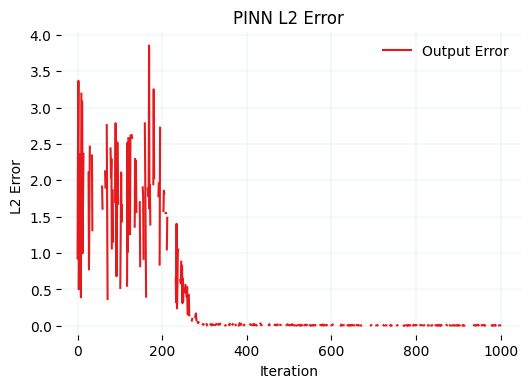

In [39]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("PINN L2 Error")
    plt.plot(L2_errors, label="Output Error")
    plt.xlabel("Iteration")
    plt.ylabel('L2 Error')             
    plt.legend()
    
    # Guardar la gráfica
    plt.savefig('ffnn_sen_physics_error_mse.png', dpi=300, bbox_inches='tight')
    
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


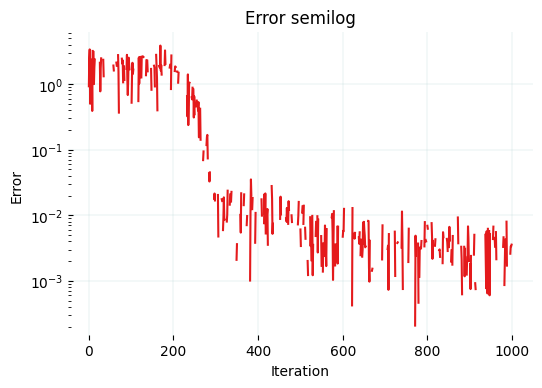

In [40]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("Error semilog")
    plt.semilogy(L2_errors)  
    plt.xlabel("Iteration")
    plt.ylabel('Error')             
    plt.legend()

    # Guardar la gráfica
    plt.savefig('ffnn_sen_physics_semilogy_loss_function.png', dpi=300, bbox_inches='tight')

    plt.show()

**Loss Function**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


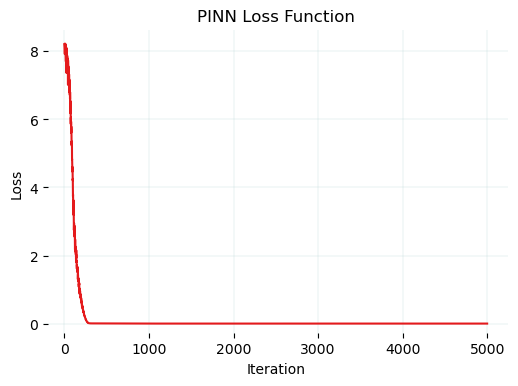

In [38]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("PINN Loss Function")
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel('Loss')             
    plt.legend()
    
    # Guardar la gráfica
    plt.savefig('ffnn_sen_physics_loss_function.png', dpi=300, bbox_inches='tight')
    
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


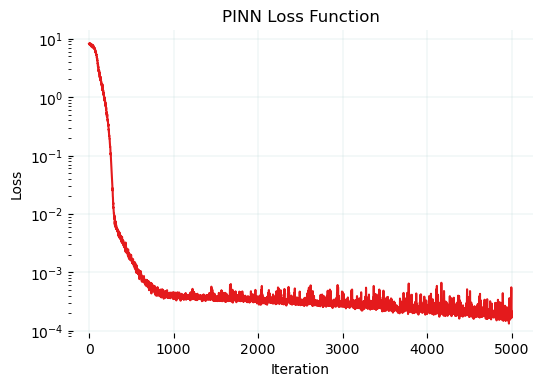

In [39]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("PINN Loss Function")
    plt.semilogy(losses)  
    plt.xlabel("Iteration")
    plt.ylabel('Loss')             
    plt.legend()

    # Guardar la gráfica
    plt.savefig('ffnn_sen_physics_semilogy_loss_function.png', dpi=300, bbox_inches='tight')

    plt.show()

##### **Error**

In [32]:
x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)

exact_function = exact_u(x_physics)
predicted_function = model(x_physics).detach()
error_between_arrays = exact_function - predicted_function

Mean Squared Error (MSE)

In [33]:
# Error relativo
output_error = torch.mean((error_between_arrays)**2)
output_error /= torch.mean(exact_function**2)
print(f"Output error: {output_error.item():.8f}")

Output error: 0.00001999


Max Error

In [34]:
max_error = torch.max(torch.abs(error_between_arrays))
max_error /= torch.max(torch.abs(exact_function))
print(f"Max error: {max_error.item():.8f}")

Max error: 0.00639049


Min Error

In [35]:
min_error = torch.min(torch.abs(error_between_arrays))
min_error /= torch.min(torch.abs(exact_function))
print(f"Min error: {min_error.item():.8f}")

Min error: 0.00061536


Avg Error

In [36]:
avg_error = torch.mean(torch.abs(error_between_arrays))
avg_error /= torch.mean(torch.abs(exact_function))
print(f"Avg error: {avg_error.item():.8f}")

Avg error: 0.00380926


**Save PINN model**

In [26]:
torch.save(model.state_dict(), "models/poisson1_pinn.pth")

In [30]:
model = FCN(1, 1, 10, 4)
model.load_state_dict(torch.load("models/poisson1_pinn.pth"))

<All keys matched successfully>

In [31]:
model.eval()

FCN(
  (fcs): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
    )
  )
  (fce): Linear(in_features=10, out_features=1, bias=True)
)